In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
weather_path = 'weather_NY_2010_2018Nov.csv'
w = pd.read_csv(weather_path)

In [3]:
w.head()

,USAF,WBAN,StationName,State,Latitude,Longitude,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce,Year,Month,Day
0,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,27.6,24.8,30.9,25.0,0.07,1.3,6.0,NaN,0,NaN,1,2010,1,1
1,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,-3.2,-20.9,17.1,-9.6,0.00,3.3,9.9,NaN,0,NaN,1,2010,1,10
2,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,20.9,17.1,24.1,15.1,0.00,6.8,12.0,19.0,0,NaN,1,2010,1,11
3,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,13.8,5.0,19.9,8.5,NaN,4.4,8.0,15.9,0,NaN,1,2010,1,12
4,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,6.3,-8.0,19.0,1.9,0.00,3.3,5.1,NaN,0,NaN,1,2010,1,13


In [4]:
len(w)

160775

In [5]:
w.loc[0]

USAF                                  726228
WBAN                                   94740
StationName         ADIRONDACK REGIONAL ARPT
State                                     NY
Latitude                              44.385
Longitude                            -74.207
MeanTemp                                27.6
MinTemp                                 24.8
MaxTemp                                 30.9
DewPoint                                25.0
Percipitation                           0.07
WindSpeed                                1.3
MaxSustainedWind                         6.0
Gust                                     NaN
Rain                                       0
SnowDepth                                NaN
SnowIce                                    1
Year                                    2010
Month                                      1
Day                                        1
Name: 0, dtype: object

In [6]:
w.dtypes

USAF                  int64
WBAN                  int64
StationName          object
State                object
Latitude            float64
Longitude           float64
MeanTemp            float64
MinTemp             float64
MaxTemp             float64
DewPoint            float64
Percipitation       float64
WindSpeed           float64
MaxSustainedWind    float64
Gust                float64
Rain                  int64
SnowDepth           float64
SnowIce               int64
Year                  int64
Month                 int64
Day                   int64
dtype: object

It appears that Rain and SnowIce are binary (either 1 or zero).

In [7]:
np.unique(w['Rain'])

array([0, 1], dtype=int64)

In [8]:
np.unique(w['SnowIce'])

array([0, 1], dtype=int64)

Look at limits on temperature. These numbers must be in Fahrenheit.

In [9]:
print(np.min(w.MinTemp))
print(np.max(w.MinTemp))

-36.9
87.8


In [10]:
np.max(w['SnowDepth'])

33.1

In [11]:
np.min(w['SnowDepth'])

0.4

Make smaller dataframe (for testing purposes).

In [12]:
#w.loc[0:99].to_csv('weather_abridged.csv', index=False)

In [13]:
#wab = pd.read_csv('weather_abridged.csv')
##wab = pd.read_csv('weather_abridged.csv', dtype = {'StationName':'string'}) # can specify dtype for individual columns

Convert date information into one datetime64 column (which I can use for convenient comparison).

In [14]:
w.loc[:, 'Date'] = pd.to_datetime(w.loc[:, ['Year', 'Month', 'Day']])

Create dataframe with date restricted to between 2016 and 2018 (to compare with 311 calls data).

In [15]:
wd = w.loc[(w['Date']>=np.datetime64('2016')) & (w['Date']<np.datetime64('2019'))]

In [16]:
print('Min Date: ', np.min(wd.Date))
print('Max Date: ', np.max(wd.Date))

Min Date:  2016-01-01 00:00:00
Max Date:  2018-11-12 00:00:00


In [17]:
len(wd)

51329

It looks like our weather data only goes through November 12 of 2018.

Look at limits on latitude and longitude. These fit with the station names, which are from all over the state of New York. I will likely want to limit to just stations in NYC.

In [18]:
print('Min Latitude: ', np.min(wd.Latitude))
print('Max Latitude: ', np.max(wd.Latitude))

Min Latitude:  40.639
Max Latitude:  44.936


From checking the 311 data, I know the minimum and maximum latitude and longitude values for calls to be:

In [19]:
min_311_lat = 40.49804421521046
max_311_lat = 40.91294056699566
min_311_long = -74.25521082506387
max_311_long = -73.70038354802529

Since I am trying to relate weather and 311 calls, I want to restrict the weather data I am looking at to this same region.

In [20]:
wdp = wd.loc[(wd['Latitude']>min_311_lat) & ((wd['Latitude']<max_311_lat)) &
           ((wd['Longitude']<max_311_long)) & ((wd['Longitude']<max_311_long))]
# Note: I could do a slightly more precise version by selecting stations, but should get largely the same results.

In [21]:
len(wdp)

6417

Check the stations that remain in the dataframe with restricted latitude and longitude. These make sense for NYC.

In [22]:
np.unique(wdp.StationName)

array(['BERGEN POINT', 'CENTRAL PARK',
       'JOHN F KENNEDY INTERNATIONAL AIRPORT', 'KINGS POINT',
       'LA GUARDIA AIRPORT', 'PORT AUTH DOWNTN MANHATTAN WALL ST HEL',
       'THE BATTERY'], dtype=object)

I don't expect too much variation in weather across NYC. For my inital modelling purposes, I will look at averages across all NYC weather stations. I could later look to see if 311 calls vary with weather on a more granualr level (by checking weather at closest weather station) but daily averages seem reasonable for now.

First, explore what data looks like for a single date. The numbers tend to be very similar, which fits with my instinct to average them together and just use a single value.

In [23]:
wdp.loc[wdp['Date'] == np.datetime64('2016-11-11')]

,USAF,WBAN,StationName,State,Latitude,Longitude,MeanTemp,MinTemp,MaxTemp,DewPoint,...,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce,Year,Month,Day,Date
20750,725053,94728,CENTRAL PARK,NY,40.779,-73.969,53.4,46.9,63.0,31.4,...,7.6,15.0,29.9,1,NaN,0,2016,11,11,2016-11-11
67850,744860,94789,JOHN F KENNEDY INTERNATIONAL AIRPORT,NY,40.639,-73.762,54.7,48.0,66.0,32.5,...,16.8,27.0,35.0,0,NaN,0,2016,11,11,2016-11-11
74094,725030,14732,LA GUARDIA AIRPORT,NY,40.779,-73.880,55.7,48.9,63.0,33.4,...,14.7,28.0,38.1,0,NaN,0,2016,11,11,2016-11-11
123307,720553,99999,PORT AUTH DOWNTN MANHATTAN WALL ST HEL,NY,40.701,-74.009,59.8,48.2,64.9,32.3,...,3.7,7.0,NaN,0,NaN,0,2016,11,11,2016-11-11


In [24]:
wdp.loc[wdp['Date'] == np.datetime64('2016-11-11'), 'MeanTemp']

20750     53.4
67850     54.7
74094     55.7
123307    59.8
Name: MeanTemp, dtype: float64

In [25]:
wdp.loc[wdp['Date'] == np.datetime64('2016-11-11'), ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
                                                    'WindSpeed', 'MaxSustainedWind', 'Gust', 'SnowDepth']].mean()

MeanTemp            55.900000
MinTemp             48.000000
MaxTemp             64.225000
DewPoint            32.400000
Percipitation        0.072500
WindSpeed           10.700000
MaxSustainedWind    19.250000
Gust                34.333333
SnowDepth                 NaN
dtype: float64

Note: pandas is ignoring NaN values when calculating the mean (as in the Gust average here).

### Making a new dataframe for daily averages from NYC stations
Make an array for all dates in data

In [26]:
dates = np.arange(np.datetime64('2016-01-01'), np.datetime64('2018-11-12'), np.timedelta64(1, 'D'))

Make dataframe to hold average value of weather data for each date. Initialize all variables except date to NaN.

In [27]:
d = {'Date': dates, 
     'MeanTemp': np.full(len(dates), np.nan, dtype='float64'), 'MinTemp': np.full(len(dates), np.nan, dtype='float64'), 
     'MaxTemp': np.full(len(dates), np.nan, dtype='float64'), 'DewPoint': np.full(len(dates), np.nan, dtype='float64'), 
     'Percipitation': np.full(len(dates), np.nan, dtype='float64'), 'WindSpeed': np.full(len(dates), np.nan, dtype='float64'), 
     'MaxSustainedWind': np.full(len(dates), np.nan, dtype='float64'), 'Gust': np.full(len(dates), np.nan, dtype='float64'),
     'SnowDepth': np.full(len(dates), np.nan, dtype='float64')}

df = pd.DataFrame(data=d)

Loop through dates and find average weather across NYC weather stations for each date.

In [28]:
for i in range(len(df)):
    temp = wdp.loc[wdp['Date'] == df.loc[i,'Date'], ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
                                                    'WindSpeed', 'MaxSustainedWind', 'Gust', 'SnowDepth']].mean()
    df.loc[i, ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
               'WindSpeed', 'MaxSustainedWind', 'Gust', 'SnowDepth']] = temp
    

In [29]:
df

,Date,MeanTemp,MinTemp,MaxTemp,DewPoint,Percipitation,WindSpeed,MaxSustainedWind,Gust,SnowDepth
0,2016-01-01,41.280,38.380,48.080,25.800000,0.0240,6.000000,15.333333,24.666667,NaN
1,2016-01-02,36.820,33.420,41.920,18.466667,0.0000,6.140000,15.733333,22.433333,NaN
2,2016-01-03,38.800,33.180,45.920,21.333333,0.0000,5.680000,14.333333,23.066667,NaN
3,2016-01-04,32.540,21.620,42.640,15.066667,0.0000,7.060000,17.700000,27.366667,NaN
4,2016-01-05,18.900,11.820,34.320,-0.500000,0.0000,7.080000,20.400000,30.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
1041,2018-11-07,57.700,50.225,63.500,45.800000,0.6875,10.833333,15.600000,29.733333,NaN
1042,2018-11-08,53.725,46.750,63.500,34.525000,0.0125,8.566667,14.666667,19.300000,NaN
1043,2018-11-09,47.775,42.250,56.325,36.125000,0.0000,9.800000,15.700000,20.000000,NaN
1044,2018-11-10,47.125,39.175,52.775,35.700000,0.7475,12.433333,22.733333,31.333333,NaN


In [30]:
df.to_csv('weather_daily_avg.csv', index=False)

SnowDepth appears to be usually NaN (for no snow), but does have a positive value sometimes.

In [31]:
np.max(df['SnowDepth'])

26.2

The weather dataframe I now have allows some easy plotting of how the weather varies with time.

In [32]:
import matplotlib.dates as mdates

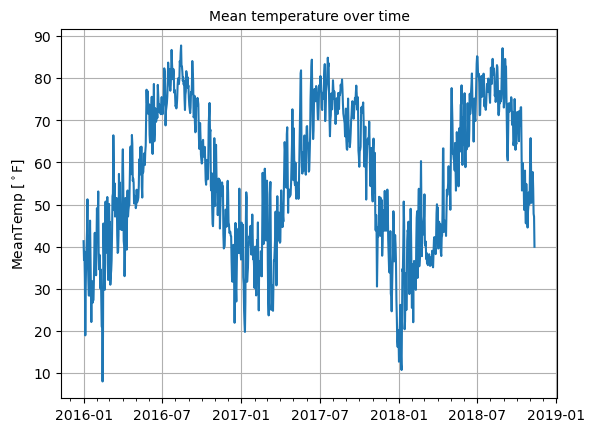

In [36]:
fig, ax = plt.subplots()
ax.plot('Date', 'MeanTemp', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'MeanTemp [$^\circ$F]')
ax.set_title('Mean temperature over time', fontsize='medium')
plt.show()

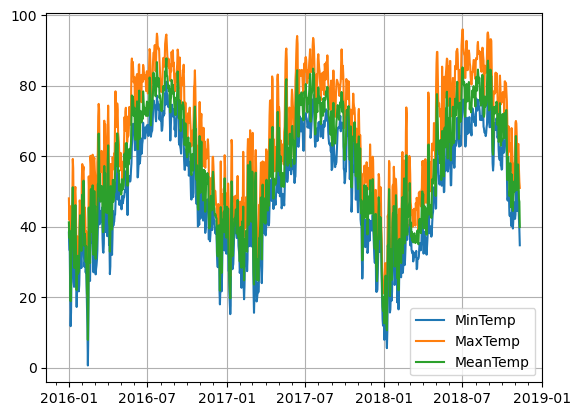

In [43]:
fig, ax = plt.subplots()
ax.plot('Date', 'MinTemp', data=df)
ax.plot('Date', 'MaxTemp', data=df)
ax.plot('Date', 'MeanTemp', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
# ax.set_ylabel(r'MeanTemp [$^\circ$F]')
# ax.set_title('Mean temperature over time', fontsize='medium')
ax.legend()
plt.show()

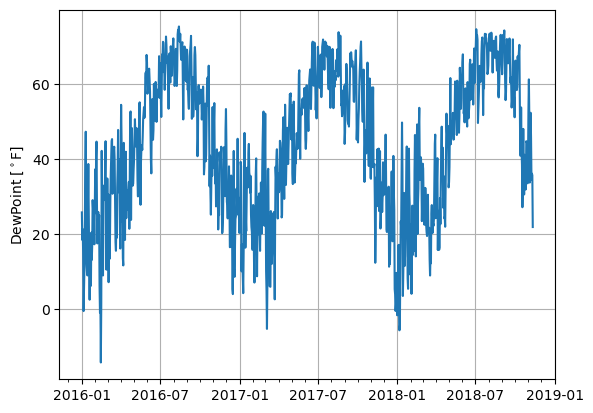

In [35]:
fig, ax = plt.subplots()
ax.plot('Date', 'DewPoint', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'DewPoint [$^\circ$F]')
plt.show()

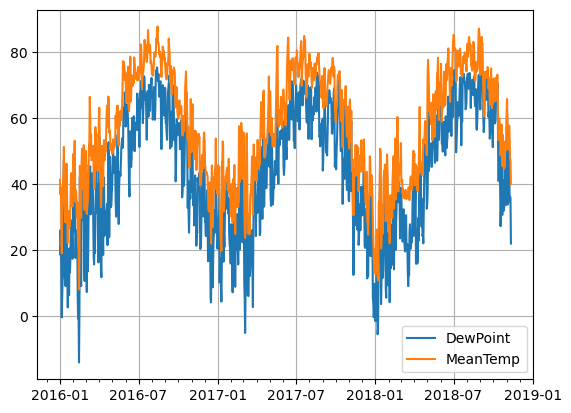

In [44]:
fig, ax = plt.subplots()
ax.plot('Date', 'DewPoint', data=df)
ax.plot('Date', 'MeanTemp', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.legend()
# ax.set_ylabel(r'DewPoint [$^\circ$F]')
plt.show()

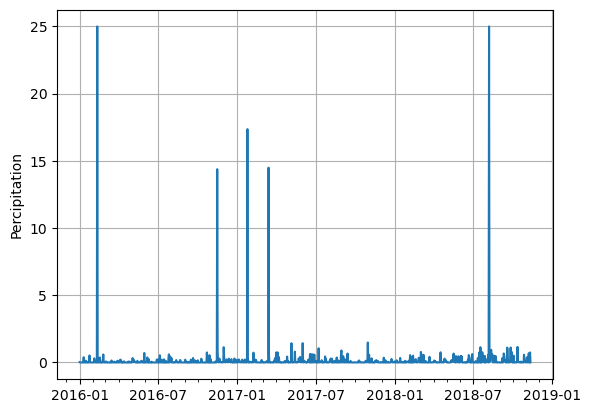

In [42]:
fig, ax = plt.subplots()
ax.plot('Date', 'Percipitation', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Percipitation')
plt.show()

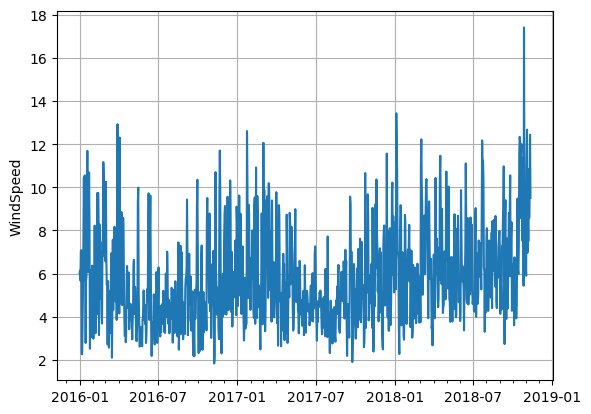

In [37]:
fig, ax = plt.subplots()
ax.plot('Date', 'WindSpeed', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'WindSpeed')
plt.show()

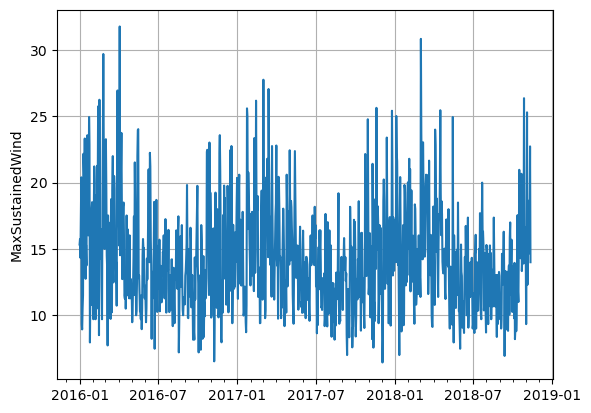

In [47]:
fig, ax = plt.subplots()
ax.plot('Date', 'MaxSustainedWind', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'MaxSustainedWind')
plt.show()

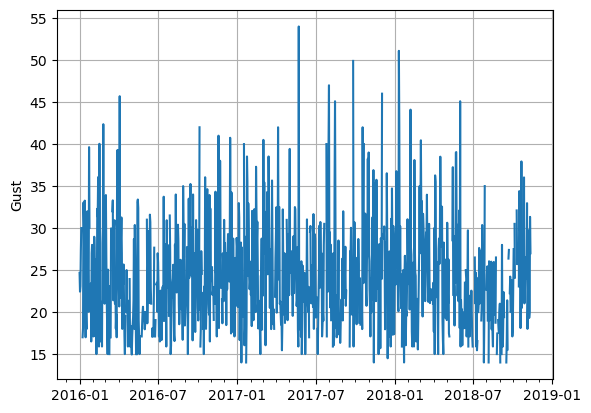

In [48]:
fig, ax = plt.subplots()
ax.plot('Date', 'Gust', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Gust')
plt.show()

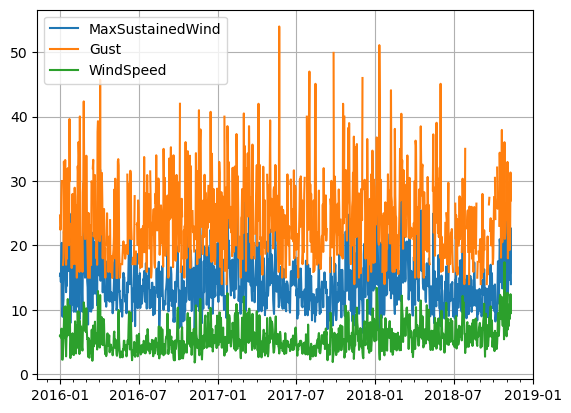

In [51]:
fig, ax = plt.subplots()

ax.plot('Date', 'MaxSustainedWind', data=df)
ax.plot('Date', 'Gust', data=df)
ax.plot('Date', 'WindSpeed', data=df)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
# ax.set_ylabel(r'MaxSustainedWind')
ax.legend()
plt.show()